In [4]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def load_data():
    mnist = datasets.fetch_openml("mnist_784", version=1, as_frame=False)
    X, y = mnist.data, mnist.target
    y = y.astype(np.int32)  # Convert target to integers
    return X, y


def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def avg_pooling(image, pool_size):
    pooled_height = image.shape[0] // pool_size[0]
    pooled_width = image.shape[1] // pool_size[1]
    pooled_image = np.zeros((pooled_height, pooled_width))

    for i in range(pooled_height):
        for j in range(pooled_width):
            start_i, end_i = i * pool_size[0], (i + 1) * pool_size[0]
            start_j, end_j = j * pool_size[1], (j + 1) * pool_size[1]
            pooled_image[i, j] = np.mean(image[start_i:end_i, start_j:end_j])

    return pooled_image


def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [5]:
import tqdm

# Load and split the data
X, y = load_data()

pool_size = 3
X_pooled = np.zeros((X.shape[0], (28 // pool_size) * (28 // pool_size)))
for i in tqdm.tqdm(range(X.shape[0])):
    image = X[i].reshape(28, 28)
    pooled_image = avg_pooling(image, (pool_size, pool_size))
    X_pooled[i] = pooled_image.flatten()

X_train, X_test, y_train, y_test = split_data(X_pooled, y)

# Preprocess the data
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
100%|██████████| 70000/70000 [00:47<00:00, 1469.44it/s]


In [6]:
import sys
sys.path.append('D:\calvera\src')

In [7]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [36]:
import torch

from neural_bandits.algorithms.neural_ucb_bandit import NeuralUCB
from neural_bandits.trainers.neural_ucb_trainer import NeuralUCBTrainer
from neural_bandits.utils.multiclass import MultiClassContextualiser

def train_neural_ucb_mnist(X_train_scaled, y_train, n_samples: int = 10000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_features = X_train_scaled.shape[1]
    n_arms = 10

    network = Network(n_features * n_arms, hidden_size=100)
    
    # Initialize bandit
    bandit = NeuralUCB(
        network=network,
        n_arms=n_arms,
        n_features=n_features * n_arms,
        lambda_=0.00001,
        nu=0.00001,
    ).to(device)
    
    trainer = NeuralUCBTrainer(eta=0.01)
    mc_contextualiser = MultiClassContextualiser(n_arms)
    
    total_regret = []
    
    for t in tqdm.tqdm(range(n_samples)):
        x_tensor = torch.tensor(X_train_scaled[t], dtype=torch.float32).to(device).reshape(1, -1)
        contextualised_actions = mc_contextualiser.contextualise(x_tensor)
        # print("contextualised_actions.shape: ", contextualised_actions.shape)
        
        # Select action
        ucb_scores = bandit(contextualised_actions)
        chosen_arm = torch.argmax(ucb_scores, dim=1).item()
        
        # Get reward
        reward = 1.0 if y_train[t] == chosen_arm else 0.0
        reward = torch.tensor([reward], dtype=torch.float32, device=device).reshape(1, -1)
        total_regret.append(1 - reward.item())
        
        # Extract features for chosen arm
        contextualised_actions = contextualised_actions.squeeze(0)
        chosen_features = contextualised_actions[chosen_arm]
        # print("chosen_features.shape: ", chosen_features.shape)
        
        # Update bandit
        if t < 1000:
            bandit = trainer.update(bandit, reward, chosen_features)
        else:
            if t % 100 == 0:
                bandit = trainer.update(bandit, reward, chosen_features)

        if t % 100 == 0:
            print(f"Step {t}:")
            print(f"UCB Scores: {ucb_scores}")
            print(f"Chosen arm: {chosen_arm}")
            print(f"True label: {y_train[t]}")
            print(f"Average regret: {sum(total_regret)/(t+1)}")
    
    return bandit, total_regret

In [37]:
# Train the neural UCB bandit
bandit, regret = train_neural_ucb_mnist(X_train_scaled, y_train)

# Print results
print("Total regret:", sum(regret))
print("Average regret:", sum(regret) / len(regret))

  0%|          | 5/10000 [00:00<03:46, 44.04it/s]

Step 0:
UCB Scores: tensor([[0.0910, 0.1041, 0.1001, 0.1032, 0.1025, 0.1057, 0.0986, 0.1043, 0.1010,
         0.0893]])
Chosen arm: 5
True label: 5
Average regret: 0.0


  1%|          | 102/10000 [00:12<30:47,  5.36it/s]

Step 100:
UCB Scores: tensor([[0.1668, 0.0742, 0.0818, 0.0819, 0.1043, 0.1183, 0.1252, 0.0622, 0.0899,
         0.0953]])
Chosen arm: 0
True label: 0
Average regret: 0.6534653465346535


  2%|▏         | 202/10000 [00:41<37:57,  4.30it/s]  

Step 200:
UCB Scores: tensor([[0.0903, 0.0777, 0.1162, 0.1237, 0.0904, 0.1338, 0.0880, 0.1006, 0.1012,
         0.0780]])
Chosen arm: 5
True label: 6
Average regret: 0.572139303482587


  3%|▎         | 301/10000 [01:11<43:24,  3.72it/s]  

Step 300:
UCB Scores: tensor([[0.0676, 0.0852, 0.1069, 0.2518, 0.0726, 0.0630, 0.0839, 0.0836, 0.0965,
         0.0890]])
Chosen arm: 3
True label: 3
Average regret: 0.5149501661129569


  4%|▍         | 401/10000 [01:53<57:57,  2.76it/s]  

Step 400:
UCB Scores: tensor([[0.0922, 0.0754, 0.0745, 0.1691, 0.0924, 0.0843, 0.0793, 0.2002, 0.0839,
         0.0487]])
Chosen arm: 7
True label: 7
Average regret: 0.486284289276808


  5%|▌         | 501/10000 [02:47<1:42:30,  1.54it/s]

Step 500:
UCB Scores: tensor([[0.0516, 0.1792, 0.0838, 0.1397, 0.0591, 0.0522, 0.0697, 0.1858, 0.0800,
         0.0990]])
Chosen arm: 7
True label: 1
Average regret: 0.4431137724550898


  6%|▌         | 601/10000 [03:41<1:03:36,  2.46it/s]

Step 600:
UCB Scores: tensor([[0.0650, 0.0803, 0.0634, 0.1017, 0.0830, 0.1109, 0.0767, 0.1640, 0.1523,
         0.1027]])
Chosen arm: 7
True label: 7
Average regret: 0.40266222961730447


  7%|▋         | 701/10000 [04:30<1:22:05,  1.89it/s]

Step 700:
UCB Scores: tensor([[0.0844, 0.1777, 0.0979, 0.1000, 0.0998, 0.0795, 0.0777, 0.0611, 0.1305,
         0.0914]])
Chosen arm: 1
True label: 1
Average regret: 0.3651925820256776


  8%|▊         | 801/10000 [05:24<1:28:05,  1.74it/s]

Step 800:
UCB Scores: tensor([[0.1436, 0.1374, 0.0985, 0.1357, 0.0991, 0.0803, 0.0722, 0.0582, 0.0801,
         0.0948]])
Chosen arm: 0
True label: 3
Average regret: 0.3408239700374532


  9%|▉         | 901/10000 [06:22<1:40:17,  1.51it/s]

Step 900:
UCB Scores: tensor([[0.1034, 0.0694, 0.0435, 0.1265, 0.0938, 0.1937, 0.0873, 0.0882, 0.0779,
         0.1163]])
Chosen arm: 5
True label: 5
Average regret: 0.3218645948945616


 10%|█         | 1022/10000 [07:26<10:34, 14.15it/s]  

Step 1000:
UCB Scores: tensor([[0.0581, 0.2063, 0.1337, 0.0888, 0.0999, 0.0846, 0.1134, 0.0762, 0.0803,
         0.0587]])
Chosen arm: 1
True label: 1
Average regret: 0.3126873126873127


 11%|█         | 1122/10000 [07:28<02:45, 53.58it/s]

Step 1100:
UCB Scores: tensor([[0.0857, 0.0516, 0.0648, 0.0785, 0.1286, 0.1039, 0.1028, 0.1127, 0.0900,
         0.1814]])
Chosen arm: 9
True label: 9
Average regret: 0.29518619436875565


 12%|█▏        | 1236/10000 [07:29<01:51, 78.42it/s] 

Step 1200:
UCB Scores: tensor([[0.1072, 0.0625, 0.0668, 0.1038, 0.1021, 0.0807, 0.0669, 0.1495, 0.1078,
         0.1528]])
Chosen arm: 9
True label: 9
Average regret: 0.29059117402164863


 13%|█▎        | 1317/10000 [07:30<02:25, 59.81it/s] 

Step 1300:
UCB Scores: tensor([[0.0811, 0.0949, 0.1040, 0.2914, 0.0665, 0.0868, 0.0662, 0.1075, 0.0713,
         0.0303]])
Chosen arm: 3
True label: 3
Average regret: 0.2851652574942352


 14%|█▍        | 1436/10000 [07:32<01:58, 72.29it/s] 

Step 1400:
UCB Scores: tensor([[0.1000, 0.0688, 0.0843, 0.1478, 0.0660, 0.2252, 0.0895, 0.0801, 0.0943,
         0.0439]])
Chosen arm: 5
True label: 5
Average regret: 0.2798001427551749


 15%|█▌        | 1527/10000 [07:33<02:34, 54.74it/s]

Step 1500:
UCB Scores: tensor([[0.1035, 0.0725, 0.0472, 0.1181, 0.1236, 0.0266, 0.0470, 0.0850, 0.1267,
         0.2498]])
Chosen arm: 9
True label: 7
Average regret: 0.27381745502998


 16%|█▌        | 1624/10000 [07:35<02:53, 48.36it/s] 

Step 1600:
UCB Scores: tensor([[0.0580, 0.0808, 0.0791, 0.1192, 0.0799, 0.1286, 0.0780, 0.1320, 0.1816,
         0.0628]])
Chosen arm: 8
True label: 8
Average regret: 0.2673329169269207


 17%|█▋        | 1731/10000 [07:36<02:15, 61.17it/s] 

Step 1700:
UCB Scores: tensor([[0.1408, 0.0797, 0.1237, 0.0535, 0.1106, 0.0626, 0.1040, 0.1466, 0.1172,
         0.0614]])
Chosen arm: 7
True label: 6
Average regret: 0.26161081716637274


 18%|█▊        | 1826/10000 [07:38<02:48, 48.51it/s] 

Step 1800:
UCB Scores: tensor([[0.0954, 0.0618, 0.0852, 0.0743, 0.1329, 0.1160, 0.1186, 0.0996, 0.1087,
         0.1076]])
Chosen arm: 4
True label: 4
Average regret: 0.25763464741810105


 19%|█▉        | 1924/10000 [07:39<02:18, 58.36it/s] 

Step 1900:
UCB Scores: tensor([[0.0797, 0.0727, 0.1152, 0.0795, 0.0644, 0.0731, 0.1125, 0.0660, 0.2470,
         0.0899]])
Chosen arm: 8
True label: 8
Average regret: 0.25092056812204105


 20%|██        | 2030/10000 [07:40<02:09, 61.53it/s] 

Step 2000:
UCB Scores: tensor([[0.0616, 0.1371, 0.0859, 0.0594, 0.1856, 0.0499, 0.0917, 0.0736, 0.0835,
         0.1718]])
Chosen arm: 4
True label: 4
Average regret: 0.2478760619690155


 21%|██▏       | 2131/10000 [07:42<02:00, 65.46it/s] 

Step 2100:
UCB Scores: tensor([[0.0857, 0.0706, 0.1936, 0.2725, 0.0343, 0.0243, 0.0756, 0.1125, 0.0629,
         0.0680]])
Chosen arm: 3
True label: 3
Average regret: 0.2441694431223227


 22%|██▏       | 2240/10000 [07:43<01:38, 78.58it/s] 

Step 2200:
UCB Scores: tensor([[0.0952, 0.0725, 0.0627, 0.0770, 0.0832, 0.0711, 0.0489, 0.2090, 0.1601,
         0.1203]])
Chosen arm: 7
True label: 7
Average regret: 0.24261699227623806


 23%|██▎       | 2320/10000 [07:44<02:20, 54.73it/s] 

Step 2300:
UCB Scores: tensor([[0.0868, 0.0731, 0.2423, 0.1536, 0.1162, 0.0870, 0.0818, 0.0709, 0.0400,
         0.0484]])
Chosen arm: 2
True label: 2
Average regret: 0.24076488483268144


 24%|██▍       | 2433/10000 [07:46<02:04, 60.88it/s] 

Step 2400:
UCB Scores: tensor([[0.2402, 0.0788, 0.0957, 0.1012, 0.0689, 0.0672, 0.1772, 0.0628, 0.0611,
         0.0467]])
Chosen arm: 0
True label: 0
Average regret: 0.23740108288213244


 25%|██▌       | 2533/10000 [07:47<02:05, 59.71it/s] 

Step 2500:
UCB Scores: tensor([[0.2160, 0.1229, 0.1002, 0.0509, 0.1142, 0.1268, 0.0948, 0.0490, 0.0535,
         0.0716]])
Chosen arm: 0
True label: 0
Average regret: 0.23630547780887645


 26%|██▋       | 2626/10000 [07:49<02:05, 58.81it/s]

Step 2600:
UCB Scores: tensor([[0.0804, 0.1517, 0.1081, 0.1808, 0.0713, 0.1066, 0.0778, 0.0828, 0.0803,
         0.0603]])
Chosen arm: 3
True label: 3
Average regret: 0.2314494425221069


 27%|██▋       | 2730/10000 [07:50<02:06, 57.31it/s] 

Step 2700:
UCB Scores: tensor([[0.0905, 0.1536, 0.1144, 0.1588, 0.0737, 0.1429, 0.0694, 0.0547, 0.0936,
         0.0485]])
Chosen arm: 3
True label: 1
Average regret: 0.22806368011847464


 28%|██▊       | 2830/10000 [07:52<02:02, 58.68it/s] 

Step 2800:
UCB Scores: tensor([[0.0646, 0.2244, 0.1336, 0.0958, 0.0813, 0.0569, 0.0818, 0.0986, 0.0837,
         0.0794]])
Chosen arm: 1
True label: 1
Average regret: 0.22777579435915746


 29%|██▉       | 2925/10000 [07:53<02:07, 55.28it/s] 

Step 2900:
UCB Scores: tensor([[0.1943, 0.0831, 0.0868, 0.0629, 0.1080, 0.0223, 0.1517, 0.1105, 0.0874,
         0.0929]])
Chosen arm: 0
True label: 0
Average regret: 0.22578421234057222


 30%|███       | 3029/10000 [07:54<01:59, 58.47it/s] 

Step 3000:
UCB Scores: tensor([[0.0640, 0.1096, 0.1417, 0.1545, 0.0922, 0.0665, 0.0611, 0.0510, 0.0994,
         0.1601]])
Chosen arm: 9
True label: 3
Average regret: 0.22592469176941019


 31%|███       | 3122/10000 [07:56<01:58, 58.28it/s]

Step 3100:
UCB Scores: tensor([[0.0617, 0.0914, 0.0818, 0.0580, 0.1668, 0.0817, 0.0946, 0.1704, 0.1082,
         0.0854]])
Chosen arm: 7
True label: 9
Average regret: 0.2234762979683973


 32%|███▏      | 3227/10000 [07:57<02:18, 49.05it/s] 

Step 3200:
UCB Scores: tensor([[0.0697, 0.0764, 0.1065, 0.1620, 0.1492, 0.0324, 0.1500, 0.0847, 0.0459,
         0.1232]])
Chosen arm: 3
True label: 4
Average regret: 0.22055607622617932


 33%|███▎      | 3323/10000 [07:59<01:59, 56.10it/s] 

Step 3300:
UCB Scores: tensor([[0.0571, 0.2448, 0.0537, 0.1148, 0.0816, 0.0711, 0.0812, 0.0781, 0.1570,
         0.0606]])
Chosen arm: 1
True label: 1
Average regret: 0.21690396849439564


 34%|███▍      | 3424/10000 [08:00<01:53, 57.86it/s] 

Step 3400:
UCB Scores: tensor([[0.0570, 0.2152, 0.1541, 0.0958, 0.0679, 0.0545, 0.0774, 0.0537, 0.1554,
         0.0690]])
Chosen arm: 1
True label: 1
Average regret: 0.21728903263745958


 35%|███▌      | 3515/10000 [08:02<02:03, 52.38it/s] 

Step 3500:
UCB Scores: tensor([[0.0664, 0.0721, 0.1227, 0.3010, 0.0676, 0.1041, 0.0526, 0.0955, 0.0783,
         0.0397]])
Chosen arm: 3
True label: 3
Average regret: 0.21536703798914597


 36%|███▋      | 3636/10000 [08:03<01:39, 64.06it/s] 

Step 3600:
UCB Scores: tensor([[0.0640, 0.1141, 0.2032, 0.0635, 0.0990, 0.0624, 0.1483, 0.0962, 0.1010,
         0.0484]])
Chosen arm: 2
True label: 2
Average regret: 0.2143848930852541


 37%|███▋      | 3742/10000 [08:04<01:20, 78.04it/s] 

Step 3700:
UCB Scores: tensor([[0.0594, 0.1565, 0.0904, 0.2291, 0.0877, 0.0464, 0.0469, 0.0689, 0.0876,
         0.1273]])
Chosen arm: 3
True label: 3
Average regret: 0.21372601999459606


 38%|███▊      | 3821/10000 [08:06<01:51, 55.30it/s] 

Step 3800:
UCB Scores: tensor([[0.1121, 0.0755, 0.1788, 0.1215, 0.1297, 0.0440, 0.1158, 0.0184, 0.0670,
         0.1371]])
Chosen arm: 2
True label: 2
Average regret: 0.2120494606682452


 39%|███▉      | 3940/10000 [08:07<01:20, 75.45it/s] 

Step 3900:
UCB Scores: tensor([[0.1018, 0.1146, 0.1486, 0.0837, 0.0803, 0.1127, 0.0788, 0.0711, 0.1565,
         0.0518]])
Chosen arm: 8
True label: 8
Average regret: 0.21250961291976417


 40%|████      | 4019/10000 [08:09<01:45, 56.66it/s] 

Step 4000:
UCB Scores: tensor([[0.0975, 0.0786, 0.0905, 0.0640, 0.1043, 0.2174, 0.0801, 0.0864, 0.1502,
         0.0311]])
Chosen arm: 5
True label: 5
Average regret: 0.21094726318420395


 41%|████▏     | 4127/10000 [08:10<01:37, 60.26it/s] 

Step 4100:
UCB Scores: tensor([[0.1156, 0.1002, 0.1190, 0.0675, 0.1357, 0.0623, 0.1468, 0.1091, 0.0677,
         0.0762]])
Chosen arm: 6
True label: 4
Average regret: 0.20970495001219214


 42%|████▏     | 4233/10000 [08:11<01:32, 62.56it/s] 

Step 4200:
UCB Scores: tensor([[0.0490, 0.2069, 0.0906, 0.1513, 0.0903, 0.0507, 0.0994, 0.1293, 0.0511,
         0.0815]])
Chosen arm: 1
True label: 1
Average regret: 0.20828374196619853


 43%|████▎     | 4323/10000 [08:13<01:33, 60.92it/s] 

Step 4300:
UCB Scores: tensor([[0.0631, 0.0516, 0.0859, 0.0660, 0.2694, 0.0895, 0.1166, 0.1097, 0.0853,
         0.0628]])
Chosen arm: 4
True label: 4
Average regret: 0.2066961171820507


 44%|████▍     | 4430/10000 [08:14<01:30, 61.42it/s] 

Step 4400:
UCB Scores: tensor([[0.2497, 0.0752, 0.1137, 0.0389, 0.0966, 0.0720, 0.0794, 0.0659, 0.1016,
         0.1071]])
Chosen arm: 0
True label: 0
Average regret: 0.20699840945239717


 45%|████▌     | 4528/10000 [08:15<01:29, 60.96it/s] 

Step 4500:
UCB Scores: tensor([[0.0609, 0.0671, 0.0549, 0.0924, 0.0669, 0.0779, 0.0620, 0.0749, 0.1422,
         0.3009]])
Chosen arm: 9
True label: 9
Average regret: 0.20550988669184625


 46%|████▋     | 4630/10000 [08:17<01:38, 54.74it/s] 

Step 4600:
UCB Scores: tensor([[0.1007, 0.1098, 0.2461, 0.0784, 0.0638, 0.0545, 0.1156, 0.0752, 0.0755,
         0.0804]])
Chosen arm: 2
True label: 2
Average regret: 0.20452075635731362


 47%|████▋     | 4726/10000 [08:18<01:22, 64.18it/s] 

Step 4700:
UCB Scores: tensor([[0.2322, 0.0650, 0.0990, 0.1245, 0.1049, 0.0767, 0.1117, 0.0792, 0.0764,
         0.0303]])
Chosen arm: 0
True label: 0
Average regret: 0.20442459051265688


 48%|████▊     | 4820/10000 [08:20<01:34, 55.01it/s] 

Step 4800:
UCB Scores: tensor([[0.1061, 0.0862, 0.0702, 0.0994, 0.1031, 0.1663, 0.1245, 0.0947, 0.0887,
         0.0608]])
Chosen arm: 5
True label: 5
Average regret: 0.20391585086440325


 49%|████▉     | 4925/10000 [08:21<01:20, 62.67it/s] 

Step 4900:
UCB Scores: tensor([[0.0669, 0.0530, 0.0885, 0.0381, 0.1705, 0.0644, 0.2323, 0.0935, 0.0675,
         0.1252]])
Chosen arm: 6
True label: 6
Average regret: 0.20261171189553154


 50%|█████     | 5028/10000 [08:22<01:12, 68.13it/s] 

Step 5000:
UCB Scores: tensor([[0.0587, 0.2325, 0.0822, 0.1156, 0.0836, 0.0695, 0.0826, 0.0694, 0.1413,
         0.0645]])
Chosen arm: 1
True label: 1
Average regret: 0.20235952809438112


 51%|█████     | 5121/10000 [08:24<01:17, 62.93it/s] 

Step 5100:
UCB Scores: tensor([[0.0664, 0.1316, 0.1039, 0.0739, 0.0901, 0.0581, 0.1072, 0.0807, 0.1803,
         0.1076]])
Chosen arm: 8
True label: 8
Average regret: 0.20133307194667713


 52%|█████▏    | 5218/10000 [08:25<01:25, 55.83it/s] 

Step 5200:
UCB Scores: tensor([[0.0713, 0.1365, 0.0700, 0.1179, 0.1034, 0.0614, 0.0570, 0.1668, 0.1135,
         0.1022]])
Chosen arm: 7
True label: 7
Average regret: 0.20015381657373582


 53%|█████▎    | 5325/10000 [08:26<01:18, 59.54it/s] 

Step 5300:
UCB Scores: tensor([[0.0707, 0.0923, 0.1090, 0.2080, 0.0951, 0.1614, 0.0691, 0.1043, 0.0667,
         0.0234]])
Chosen arm: 3
True label: 3
Average regret: 0.19920769666100735


 54%|█████▍    | 5426/10000 [08:28<01:15, 60.33it/s] 

Step 5400:
UCB Scores: tensor([[0.0687, 0.1353, 0.2370, 0.0618, 0.0779, 0.0377, 0.1412, 0.0508, 0.0637,
         0.1260]])
Chosen arm: 2
True label: 2
Average regret: 0.19866691353453064


 55%|█████▌    | 5519/10000 [08:29<01:22, 54.26it/s] 

Step 5500:
UCB Scores: tensor([[0.1029, 0.0452, 0.1031, 0.0608, 0.0858, 0.1792, 0.1097, 0.0928, 0.1589,
         0.0616]])
Chosen arm: 5
True label: 5
Average regret: 0.19869114706417015


 56%|█████▋    | 5629/10000 [08:31<01:15, 57.74it/s] 

Step 5600:
UCB Scores: tensor([[0.0566, 0.0817, 0.0780, 0.1033, 0.1234, 0.1266, 0.1066, 0.0497, 0.1419,
         0.1324]])
Chosen arm: 8
True label: 8
Average regret: 0.19710765934654526


 57%|█████▋    | 5735/10000 [08:32<01:09, 61.69it/s] 

Step 5700:
UCB Scores: tensor([[0.0863, 0.0832, 0.0558, 0.0985, 0.1556, 0.1005, 0.0876, 0.1754, 0.0991,
         0.0580]])
Chosen arm: 7
True label: 4
Average regret: 0.19698298544115067


 58%|█████▊    | 5838/10000 [08:34<00:55, 75.35it/s]

Step 5800:
UCB Scores: tensor([[0.0986, 0.0649, 0.0668, 0.0473, 0.1765, 0.1177, 0.1293, 0.0694, 0.1051,
         0.1245]])
Chosen arm: 4
True label: 4
Average regret: 0.1963454576797104


 59%|█████▉    | 5921/10000 [08:35<01:08, 59.23it/s] 

Step 5900:
UCB Scores: tensor([[0.1177, 0.0816, 0.0731, 0.0852, 0.0721, 0.1648, 0.0870, 0.1386, 0.1462,
         0.0336]])
Chosen arm: 5
True label: 5
Average regret: 0.195051686154889


 60%|██████    | 6020/10000 [08:36<01:08, 58.36it/s] 

Step 6000:
UCB Scores: tensor([[0.0768, 0.0446, 0.0606, 0.0637, 0.2411, 0.0768, 0.1237, 0.1182, 0.0959,
         0.0985]])
Chosen arm: 4
True label: 4
Average regret: 0.1954674220963173


 61%|██████    | 6124/10000 [08:38<01:03, 61.50it/s] 

Step 6100:
UCB Scores: tensor([[0.0797, 0.1379, 0.1250, 0.2311, 0.0522, 0.0914, 0.1070, 0.0814, 0.0499,
         0.0444]])
Chosen arm: 3
True label: 3
Average regret: 0.19521389936076053


 62%|██████▏   | 6227/10000 [08:39<01:07, 56.01it/s] 

Step 6200:
UCB Scores: tensor([[0.2156, 0.0420, 0.0919, 0.0571, 0.0850, 0.1105, 0.1590, 0.0854, 0.0680,
         0.0855]])
Chosen arm: 0
True label: 0
Average regret: 0.19416223189808096


 63%|██████▎   | 6334/10000 [08:41<01:04, 56.42it/s] 

Step 6300:
UCB Scores: tensor([[0.0942, 0.0813, 0.0651, 0.1010, 0.0886, 0.1394, 0.0998, 0.1062, 0.1376,
         0.0867]])
Chosen arm: 5
True label: 8
Average regret: 0.19346135534042216


 64%|██████▍   | 6419/10000 [08:42<01:03, 56.41it/s] 

Step 6400:
UCB Scores: tensor([[0.0751, 0.0649, 0.1312, 0.2904, 0.0953, 0.0807, 0.0702, 0.0652, 0.0650,
         0.0620]])
Chosen arm: 3
True label: 3
Average regret: 0.192001249804718


 65%|██████▌   | 6525/10000 [08:43<00:54, 63.37it/s] 

Step 6500:
UCB Scores: tensor([[0.1057, 0.1142, 0.0997, 0.1516, 0.0980, 0.0885, 0.1181, 0.0724, 0.0749,
         0.0767]])
Chosen arm: 3
True label: 8
Average regret: 0.19243193354868482


 66%|██████▌   | 6616/10000 [08:45<00:59, 56.67it/s] 

Step 6600:
UCB Scores: tensor([[0.0678, 0.2077, 0.1091, 0.1475, 0.0566, 0.0681, 0.1238, 0.0918, 0.0732,
         0.0545]])
Chosen arm: 1
True label: 8
Average regret: 0.1920921072564763


 67%|██████▋   | 6717/10000 [08:46<00:54, 59.80it/s] 

Step 6700:
UCB Scores: tensor([[0.0684, 0.2340, 0.1108, 0.0968, 0.0777, 0.0674, 0.0783, 0.0848, 0.1269,
         0.0549]])
Chosen arm: 1
True label: 1
Average regret: 0.19131472914490374


 68%|██████▊   | 6818/10000 [08:47<00:59, 53.34it/s] 

Step 6800:
UCB Scores: tensor([[0.0787, 0.0886, 0.1161, 0.2753, 0.0496, 0.1527, 0.0696, 0.1112, 0.0366,
         0.0216]])
Chosen arm: 3
True label: 3
Average regret: 0.190854286134392


 69%|██████▉   | 6933/10000 [08:49<00:48, 62.93it/s] 

Step 6900:
UCB Scores: tensor([[0.1098, 0.0968, 0.1319, 0.1219, 0.0838, 0.0910, 0.1118, 0.0678, 0.1130,
         0.0723]])
Chosen arm: 2
True label: 8
Average regret: 0.19084190697000436


 70%|███████   | 7024/10000 [08:50<00:56, 52.66it/s] 

Step 7000:
UCB Scores: tensor([[0.2582, 0.0694, 0.1154, 0.0538, 0.0974, 0.0901, 0.1254, 0.0522, 0.0771,
         0.0610]])
Chosen arm: 0
True label: 0
Average regret: 0.19040137123268105


 71%|███████   | 7115/10000 [08:52<01:01, 47.10it/s] 

Step 7100:
UCB Scores: tensor([[0.1152, 0.2410, 0.1223, 0.0676, 0.0593, 0.0927, 0.0863, 0.0629, 0.1087,
         0.0440]])
Chosen arm: 1
True label: 8
Average regret: 0.19067736938459373


 72%|███████▏  | 7216/10000 [08:53<01:02, 44.83it/s] 

Step 7200:
UCB Scores: tensor([[0.0856, 0.1104, 0.1223, 0.1229, 0.0962, 0.0389, 0.1514, 0.1029, 0.0802,
         0.0894]])
Chosen arm: 6
True label: 3
Average regret: 0.19080683238439106


 73%|███████▎  | 7325/10000 [08:55<00:51, 51.74it/s]

Step 7300:
UCB Scores: tensor([[0.0909, 0.1393, 0.2058, 0.0658, 0.0808, 0.0488, 0.1070, 0.0583, 0.0880,
         0.1154]])
Chosen arm: 2
True label: 2
Average regret: 0.19093274893850157


 74%|███████▍  | 7434/10000 [08:57<00:36, 69.49it/s] 

Step 7400:
UCB Scores: tensor([[0.0871, 0.0461, 0.1032, 0.0984, 0.1087, 0.0634, 0.1113, 0.0731, 0.1759,
         0.1329]])
Chosen arm: 8
True label: 8
Average regret: 0.19051479529793272


 75%|███████▌  | 7518/10000 [08:58<00:51, 48.38it/s] 

Step 7500:
UCB Scores: tensor([[0.1043, 0.0787, 0.0763, 0.0650, 0.1129, 0.0503, 0.0814, 0.0652, 0.1206,
         0.2452]])
Chosen arm: 9
True label: 9
Average regret: 0.18904146113851486


 76%|███████▋  | 7625/10000 [09:00<00:42, 55.84it/s] 

Step 7600:
UCB Scores: tensor([[0.2242, 0.0393, 0.1080, 0.0536, 0.0946, 0.1573, 0.1476, 0.0368, 0.0823,
         0.0564]])
Chosen arm: 0
True label: 0
Average regret: 0.18852782528614656


 77%|███████▋  | 7730/10000 [09:01<00:33, 68.53it/s] 

Step 7700:
UCB Scores: tensor([[0.0815, 0.0642, 0.0524, 0.1265, 0.0420, 0.2410, 0.0578, 0.1184, 0.1789,
         0.0373]])
Chosen arm: 5
True label: 5
Average regret: 0.18776782236073236


 78%|███████▊  | 7838/10000 [09:02<00:25, 84.94it/s] 

Step 7800:
UCB Scores: tensor([[0.0831, 0.1270, 0.1100, 0.2263, 0.0857, 0.1243, 0.0677, 0.1096, 0.0500,
         0.0162]])
Chosen arm: 3
True label: 3
Average regret: 0.18741187027304193


 79%|███████▉  | 7925/10000 [09:03<00:29, 70.84it/s] 

Step 7900:
UCB Scores: tensor([[0.0624, 0.1181, 0.1598, 0.1312, 0.0771, 0.0824, 0.1789, 0.0417, 0.0851,
         0.0632]])
Chosen arm: 6
True label: 2
Average regret: 0.18719149474750033


 80%|████████  | 8032/10000 [09:05<00:32, 59.66it/s] 

Step 8000:
UCB Scores: tensor([[0.2364, 0.0514, 0.0966, 0.0525, 0.1170, 0.1289, 0.0623, 0.0928, 0.0907,
         0.0713]])
Chosen arm: 0
True label: 0
Average regret: 0.18635170603674542


 81%|████████▏ | 8141/10000 [09:06<00:23, 77.97it/s] 

Step 8100:
UCB Scores: tensor([[0.0620, 0.2066, 0.0718, 0.0988, 0.0612, 0.0806, 0.1102, 0.0583, 0.1928,
         0.0576]])
Chosen arm: 1
True label: 1
Average regret: 0.18639674114306876


 82%|████████▏ | 8225/10000 [09:08<00:31, 57.16it/s] 

Step 8200:
UCB Scores: tensor([[0.0723, 0.1002, 0.0763, 0.0958, 0.2126, 0.0880, 0.1091, 0.0844, 0.0547,
         0.1065]])
Chosen arm: 4
True label: 4
Average regret: 0.1869284233630045


 83%|████████▎ | 8344/10000 [09:09<00:21, 77.17it/s] 

Step 8300:
UCB Scores: tensor([[0.0522, 0.2246, 0.0795, 0.1274, 0.1018, 0.0729, 0.1133, 0.1129, 0.0586,
         0.0569]])
Chosen arm: 1
True label: 1
Average regret: 0.1863630887844838


 84%|████████▍ | 8424/10000 [09:10<00:26, 59.53it/s] 

Step 8400:
UCB Scores: tensor([[0.0609, 0.0795, 0.0382, 0.1196, 0.1069, 0.1116, 0.1017, 0.1406, 0.0831,
         0.1579]])
Chosen arm: 9
True label: 4
Average regret: 0.18628734674443517


 85%|████████▌ | 8529/10000 [09:12<00:25, 57.80it/s] 

Step 8500:
UCB Scores: tensor([[0.0971, 0.0578, 0.1009, 0.0973, 0.1279, 0.0753, 0.0738, 0.2007, 0.0674,
         0.1018]])
Chosen arm: 7
True label: 7
Average regret: 0.18574285378190802


 86%|████████▋ | 8633/10000 [09:13<00:22, 61.39it/s] 

Step 8600:
UCB Scores: tensor([[0.0634, 0.2293, 0.1074, 0.0873, 0.0822, 0.0680, 0.0839, 0.0993, 0.1160,
         0.0631]])
Chosen arm: 1
True label: 1
Average regret: 0.1861411463783281


 87%|████████▋ | 8729/10000 [09:15<00:21, 58.84it/s] 

Step 8700:
UCB Scores: tensor([[0.0649, 0.0967, 0.1151, 0.0931, 0.1047, 0.0780, 0.1014, 0.1019, 0.1635,
         0.0807]])
Chosen arm: 8
True label: 8
Average regret: 0.18584070796460178


 88%|████████▊ | 8835/10000 [09:16<00:15, 73.09it/s] 

Step 8800:
UCB Scores: tensor([[0.0835, 0.0485, 0.1293, 0.0779, 0.1283, 0.1406, 0.1383, 0.1177, 0.0655,
         0.0705]])
Chosen arm: 5
True label: 6
Average regret: 0.1853198500170435


 89%|████████▉ | 8933/10000 [09:17<00:17, 61.58it/s] 

Step 8900:
UCB Scores: tensor([[0.1522, 0.1042, 0.0736, 0.0596, 0.0815, 0.1187, 0.1157, 0.0973, 0.0592,
         0.1381]])
Chosen arm: 0
True label: 6
Average regret: 0.18503538928210314


 90%|█████████ | 9019/10000 [09:19<00:17, 55.39it/s] 

Step 9000:
UCB Scores: tensor([[0.0962, 0.0730, 0.2071, 0.0847, 0.1270, 0.0548, 0.1168, 0.0512, 0.0777,
         0.1115]])
Chosen arm: 2
True label: 2
Average regret: 0.18453505166092657


 91%|█████████ | 9119/10000 [09:20<00:15, 55.85it/s] 

Step 9100:
UCB Scores: tensor([[0.1013, 0.0356, 0.0800, 0.2105, 0.0586, 0.1754, 0.1235, 0.0794, 0.0859,
         0.0498]])
Chosen arm: 3
True label: 3
Average regret: 0.18360619712119547


 92%|█████████▏| 9220/10000 [09:22<00:13, 58.66it/s] 

Step 9200:
UCB Scores: tensor([[0.0453, 0.2015, 0.1286, 0.0808, 0.1049, 0.0737, 0.1122, 0.1010, 0.0901,
         0.0618]])
Chosen arm: 1
True label: 1
Average regret: 0.18421910661884577


 93%|█████████▎| 9323/10000 [09:23<00:10, 61.60it/s] 

Step 9300:
UCB Scores: tensor([[0.1592, 0.0441, 0.0312, 0.2075, 0.1051, 0.1529, 0.0561, 0.0540, 0.0514,
         0.1385]])
Chosen arm: 3
True label: 5
Average regret: 0.1841737447586281


 94%|█████████▍| 9423/10000 [09:24<00:09, 58.69it/s] 

Step 9400:
UCB Scores: tensor([[0.1034, 0.0363, 0.0712, 0.1114, 0.0714, 0.2013, 0.1027, 0.1087, 0.0946,
         0.0991]])
Chosen arm: 5
True label: 5
Average regret: 0.18381023295394108


 95%|█████████▌| 9531/10000 [09:26<00:07, 65.63it/s] 

Step 9500:
UCB Scores: tensor([[0.2519, 0.0658, 0.0957, 0.0882, 0.0736, 0.0728, 0.1343, 0.0465, 0.0731,
         0.0981]])
Chosen arm: 0
True label: 0
Average regret: 0.1831386169876855


 96%|█████████▋| 9631/10000 [09:27<00:06, 59.40it/s] 

Step 9600:
UCB Scores: tensor([[0.1096, 0.0597, 0.0545, 0.1184, 0.0876, 0.2469, 0.1019, 0.0688, 0.0995,
         0.0530]])
Chosen arm: 5
True label: 5
Average regret: 0.18237683574627642


 97%|█████████▋| 9729/10000 [09:29<00:04, 57.73it/s] 

Step 9700:
UCB Scores: tensor([[0.2649, 0.0511, 0.0974, 0.0760, 0.0789, 0.0881, 0.1116, 0.0717, 0.0838,
         0.0766]])
Chosen arm: 0
True label: 0
Average regret: 0.1819400061849294


 98%|█████████▊| 9814/10000 [09:30<00:03, 59.00it/s] 

Step 9800:
UCB Scores: tensor([[0.2200, 0.0985, 0.1159, 0.0733, 0.0870, 0.0606, 0.1491, 0.1092, 0.0542,
         0.0324]])
Chosen arm: 0
True label: 0
Average regret: 0.18181818181818182


 99%|█████████▉| 9934/10000 [09:31<00:00, 69.24it/s] 

Step 9900:
UCB Scores: tensor([[0.1010, 0.0494, 0.0772, 0.0859, 0.0878, 0.2174, 0.1413, 0.0910, 0.0894,
         0.0596]])
Chosen arm: 5
True label: 5
Average regret: 0.1812948187051813


100%|██████████| 10000/10000 [09:32<00:00, 17.48it/s]

Total regret: 1811.0
Average regret: 0.1811


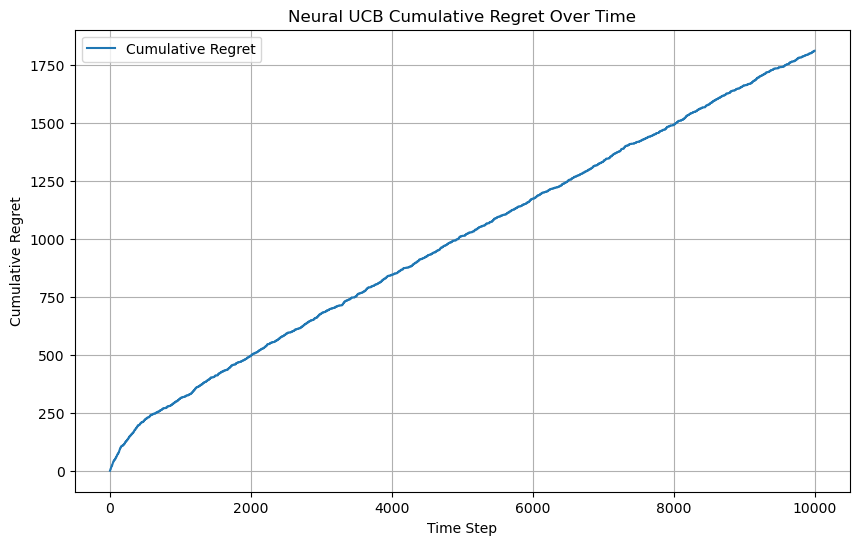

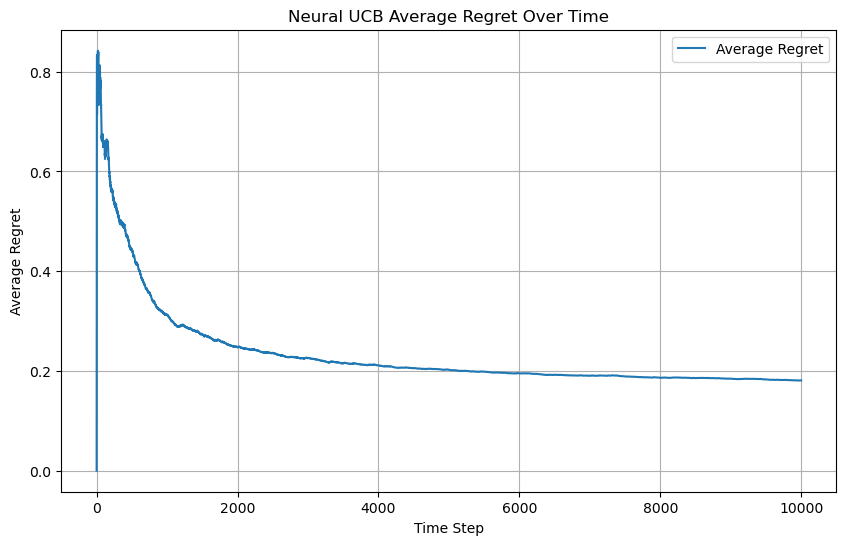

In [38]:
import matplotlib.pyplot as plt

def plot_regret(regret):
    # Convert to numpy array if it's a list
    regret = np.array(regret)
    
    # Plot cumulative regret
    plt.figure(figsize=(10, 6))
    cumulative_regret = np.cumsum(regret)
    plt.plot(cumulative_regret, label='Cumulative Regret')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Regret')
    plt.title('Neural UCB Cumulative Regret Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot average regret
    plt.figure(figsize=(10, 6))
    steps = np.arange(1, len(cumulative_regret) + 1)  # create step array first
    average_regret = cumulative_regret / steps
    plt.plot(average_regret, label='Average Regret')
    plt.xlabel('Time Step')
    plt.ylabel('Average Regret')
    plt.title('Neural UCB Average Regret Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
# After training:
plot_regret(regret)